# Blackbox Image Recognition

* no computer vision or deep learning knowledge required
* Python requirements:

In [1]:
#!pip install --upgrade tensorflow
#!pip install --upgrade numpy
#!pip install --upgrade matplotlib
#!pip install --upgrade tqdm
#!pip install --upgrade opencv-python

## Theory

### Convolution Basics

<img src="https://cdn-images-1.medium.com/max/1600/1*ZCjPUFrB6eHPRi4eyP6aaA.gif" width="360" />

*Note: CNN input image size can be arbitrary*

### Convolutional Neural Network

* example network: AlexNet<br>
<img src="http://www.mdpi.com/remotesensing/remotesensing-09-00848/article_deploy/html/images/remotesensing-09-00848-g001.png" width="600" /><br>

* main difference between fully connected and CNN: learning weights between all units in adjacent layers vs. learning filter kernels<br>
<img src="https://indoml.files.wordpress.com/2018/03/convolution-with-multiple-filters2.png?w=979" width="600" />

### Possible Approaches
1. training from scratch
2. using pretrained model
    * fine-tuning
        * replace and retrain classifier, fine-tune kernel weights
    * transfer learning
        * remove classifier or part of the classifier, use fully-connected weights as features or feature maps, train standalone linear classifier
  
#### Choosing the approach based on the dataset
* small dataset, similar to the original dataset &rarr; tranfer learning from "fully-connected features"
* large dataset, similar to the original dataset &rarr; fine-tuning part of the network
* small dataset, different from the original dataset &rarr; transfer learning from feature maps
* large dataset, different from the original dataset &rarr; training from scratch or fine-tuning whole network

Examples for all approaches can be found in [Keras documentation](https://keras.io/applications/), theory in [CS231n](http://cs231n.github.io/).

#### Jupyter Notebook related hint: Autoreload

In [2]:
from autoreload_example import some_function

In [3]:
some_function()

Before...


Change the print statement in the function and call the function again.

In [4]:
some_function()

Before...


In [5]:
%load_ext autoreload
%autoreload 2

In [50]:
some_function()

After...


## Hands-on - Transfer Learning

Import necessary packages, convolutional neural network based on VGG16 architecture (image below) and use iPython magic to show plots inside the notebook.

In [7]:
%%capture --no-stdout
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import utilities as utils

from tqdm import tqdm_notebook

from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

%matplotlib inline

<img src="https://cdn-images-1.medium.com/max/1600/1*U8uoGoZDs8nwzQE3tOhfkw@2x.png" width="300" />

Load images for four classes "randomly" chosen from [DeepFashion](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) dataset, resize them and crop the into the square shape. Our dataset is really small so we can keep everything in the memory.

In [8]:
dim = 224
data_dir = "data"

labels = ["leggins", "jeans", "dress", "blouse", "test"]
labels_map = {target: label for target, label in enumerate(labels)}

images = []
targets = []
test = []

for target, label in tqdm_notebook(enumerate(labels)):
    paths = glob.glob(os.path.join(data_dir, label, "*.jpg"))
    
    for path in paths:
        img = cv2.imread(path)
        img = utils.resize_crop(img, dim, dim)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        if label == "test":
            test.append(img)
        else:
            images.append(img)
            targets.append(target)
        
images = np.array(images)
targets = np.array(targets)
test = np.array(test)

A Jupyter Widget

Take a look at the images shape...

In [9]:
images.shape

(241, 224, 224, 3)

... and some images from the dataset.

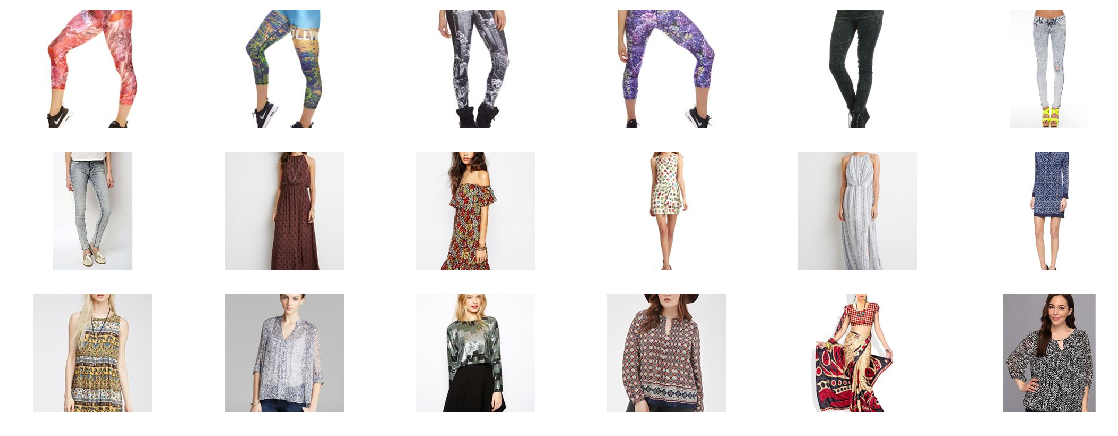

In [10]:
utils.plot_sample(images)

Now we can load the pretrained model...

In [11]:
base_model = VGG16(weights="imagenet")
print(base_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

... select intermediate layer...

In [12]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc1").output)

... and extract the features.

In [13]:
images_processed = preprocess_input(images.astype(np.float32))
features = model.predict(images_processed, verbose=1)

241/241 [==============================] - 169s 702ms/step


### Classification

Now we can build a simple classifier. For simplification no train/test split, no metrics, just pure prediction.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(features, targets)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [15]:
test_processed = preprocess_input(test.astype(np.float32))
test_features = model.predict(test_processed, verbose=1)
predictions = clf.predict_proba(test_features)

4/4 [==============================] - 2s 531ms/step


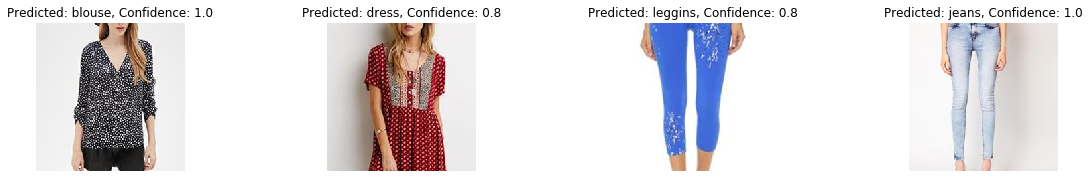

In [16]:
plt.figure(figsize=(20, 6))
for i, image in enumerate(test):
    plt.subplot(2, len(test), i + 1)
    plt.imshow(image)
    plt.title("Predicted: {}, Confidence: {}".format(labels_map[np.argmax(predictions[i])],
                                                     np.max(predictions[i])))
    plt.axis("off")
plt.show()

### Indexing and Retrieval

Imagine our client sells clothing using an eshop. We are asked to implement advanced recommendation system, where customers can upload picture of their favorite piece of clothing and they will be recommended similar items.

We have the features of our products computed already, we just need to index (store) them in suitable data structure. Let's use [K-d tree](https://en.wikipedia.org/wiki/K-d_tree) (another good choice would be for example [FLANN](https://www.cs.ubc.ca/research/flann/) for speed improvement).

In [19]:
from sklearn.neighbors import KDTree

tree = KDTree(features)

Compute the features for the query image...

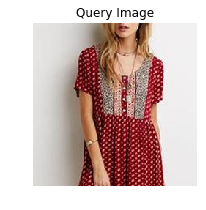

In [41]:
query = test[1]

query_processed = preprocess_input(query.reshape(1, *query.shape).astype(np.float32))
query_features = model.predict(query_processed)

plt.figure(figsize=(3, 3))
plt.imshow(query)
plt.title("Query Image")
plt.axis("off")
plt.show()

... and plot nearest neighbors.

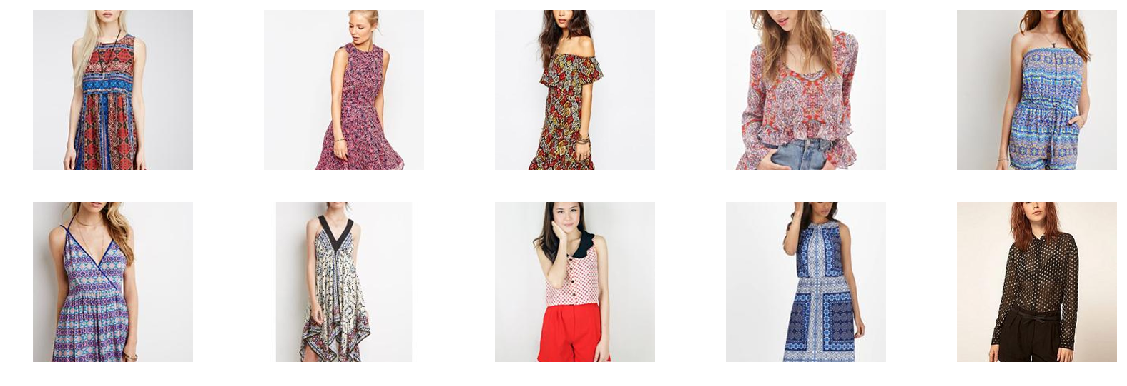

In [49]:
neighbors = 10

distances, indices = tree.query(query_features.reshape(1, -1), k=neighbors)

utils.plot_sample(images[indices[0]], columns=5, images_count=neighbors, shuffle=False)